# Homomorphic Encryption and Federated Learning based Privacy-Preserving: Breast cancer detection Use-Case

## Abstract

Medical data is often highly sensitive in terms of data privacy and security concerns. Federated learning, one type of machine learning techniques, has been started to use for the improvement of the privacy and security of medical data. In the federated learning, the training data is distributed across multiple machines, and the
learning process is performed in a collaborative manner. There are several privacy attacks on machine learning (ML) models to get the sensitive information by attackers. Therefore, the ML model itself should be protected from the adversarial attack, especially for applications using medical data. One of the solutions for this problem is homomorphic encryption-based model protection from the adversary collaborator. This project proposes a privacy-preserving federated learning algorithm for medical data using homomorphic encryption. The proposed algorithm uses a secure multi-party computation protocol to protect the machine learning model from the adversaries. In this study, the proposed algorithm using a real-world medical dataset is evaluated in terms of the model performance.

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-09-25T13:25:31.014219+02:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 9.5.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-83-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit



Before step into federated learning, lets talk about Logistic Regression - a local training method we use in our federated learning process.

## Datasets

In [2]:
import pandas as pd

# we use another datasets to demo our Logistic Regression
df = pd.read_csv("data/breast-cancer.csv")

# define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

# swap "diagnosis" and "fractal_dimension_worst" columns
df = swap_columns(df, 'diagnosis', 'fractal_dimension_worst')
df.head()

,id,fractal_dimension_worst,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,diagnosis
0,842302,0.11890,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,M
1,842517,0.08902,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,M
2,84300903,0.08758,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,M
3,84348301,0.17300,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,M
4,84358402,0.07678,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,M


## Data Preprocessing

In [3]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from torch.autograd import Variable

Replace "M" with 1 and "B" with 0 at "diagnosis" column 

In [4]:
# replace "M" with 1 and "B" with 0
df["diagnosis"] = (df["diagnosis"] == "M").astype(int)

We define some functions in order to randomly split this dataset to:
- Training dataset (80%)
- Testing dataset  (20%)

In [5]:
def print_dataset(name, data):
    print('Dataset {}. Shape: {}'.format(name, data.shape))
    print(data[:5])
    
def scale_dataset(df, overSample=False):
    # split to fetures and diagnostic result
    X = df[df.columns[:-1]].values
    Y = df[df.columns[-1]].values
    
    # standardize the input features 
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # balance the class distribution
    if overSample:
        ros = RandomOverSampler()
        X, Y = ros.fit_resample(X, Y)

    data = np.hstack((X, np.reshape(Y, (-1, 1))))
    
    # convert to tensor context
    X_train_tensor = Variable(torch.tensor(X, dtype = torch.float32))
    Y_train_tensor = Variable(torch.tensor(Y, dtype = torch.float32))
    data_tensor    = Variable(torch.tensor(data, dtype = torch.float32))
    
    return data_tensor, X_train_tensor, Y_train_tensor

In [6]:
# split dataframe to train and test df
df_train, df_test = np.split(df.sample(frac=1), [int(0.8 * len(df))])

# scaling and convert to tensor context
train, X_train, Y_train = scale_dataset(df_train, True)
test , X_test , Y_test  = scale_dataset(df_test , False)
train

/home/enotari/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


tensor([[ 0.4948, -0.0421,  0.2342,  ...,  0.3296,  0.0579,  0.0000],
        [-0.2353, -1.2130,  0.2713,  ..., -0.7880,  0.4942,  1.0000],
        [-0.2422,  1.7849, -0.2885,  ...,  1.4277,  1.5374,  1.0000],
        ...,
        [-0.2352,  0.7632,  1.9252,  ...,  2.1309,  0.0188,  1.0000],
        [-0.2357, -0.3027,  0.2628,  ...,  0.5635, -0.3785,  1.0000],
        [-0.2358, -0.5436,  1.2654,  ...,  0.5015, -0.9008,  1.0000]])

## Logistic Regression

We define our machine learning model, which is a logistic regression model. Why? Because this medical dataset is linearly separable, which simplifies things a lot.

We can create the logistic regression model with the following code (we will using [pyTorch](https://en.wikipedia.org/wiki/PyTorch) in our project)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features):
        # init super class of LogisticRegression
        super(LogisticRegression, self).__init__()
        
        # create "linear neural network"
        input_dim  = num_features
        output_dim = 1
        self.linear = torch.nn.Linear(input_dim, output_dim)

        # initialize Weights and Bias
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In our “forward” pass of the PyTorch neural network (really just a perceptron), Logistic regression can also be visualized as a network of features feeding into a single logistic function, the visual representation and corresponding equations are shown below:

<p align='center'>
    <img src='images/logistic_model_overview.png'>
</p>

### Sigmoid function

The sigmoid function is extremely useful for two main reasons:

* It transforms our linear regression output to a probability from 0 to 1. We can then take any probability greater than 0.5 as being 1 and below as being 0.

* Unlike a stepwise function (which would transform the data into the binary case as well), the sigmoid is differentiable, which is necessary for optimizing the parameters using gradient descent (we will show later).

<p align='center'>
    <img src='images/sigmoid.png'>
</p>

### Training process

Firstly, we should assign some hyper-parameters

In [9]:
input_dim = 31 # numbers of features 
epochs = 10000
learning_rate = 0.01

Parameter Definitions:

* **Epoch**: Indicates the number of passes through the entire training dataset the network has completed.
* **learning_rate**: A tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.

In [10]:
from tqdm.notebook import tqdm

def decide(y):
    return 1. if y >= 0.5 else 0.

decide_vectorized = np.vectorize(decide)
to_percent = lambda x: '{:.2f}%'.format(x)

def compute_accuracy(model, input, output):
    prediction = model(input).data.numpy()[:, 0]
    n_samples = prediction.shape[0] + 0.
    prediction = decide_vectorized(prediction)
    equal = prediction == output.data.numpy()
    return 100. * equal.sum() / n_samples

def Training(X_train, Y_train, X_test, Y_test, debug=True):
    model = LogisticRegression(input_dim)
    n_samples, _ = X_train.shape
    
    # record losses and accuracies during training
    losses = []
    accuracies = []
    
    # define criterion function and set up optimizer
    criterion = torch.nn.BCELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    
    # main process
    for epoch in tqdm(range(epochs)):  
        optimizer.zero_grad()
        #### Compute outputs ####
        prediction = model(X_train)
        
        #### Compute gradients ####
        loss = criterion(prediction.squeeze(), Y_train)
        
        loss.backward()
        
        #### Update weights #### 
        optimizer.step()
            
        #### Logging ####
        if debug and (epoch + 1)%50 == 0:
            # compute accuracy and loss
            train_acc = compute_accuracy(model, X_train, Y_train)
            train_loss = loss.item()
            losses.append(train_loss)
            accuracies.append(train_acc)
            
            print('[LOG] Epoch: %05d' % (epoch + 1), end="")
            print('    | Train ACC: %s' % to_percent(train_acc), end="")
            print('    | Loss: %.3f' % train_loss)

    recorded = [accuracies, losses]
    return model, recorded

In this above code, we introduce two important functions: the Loss Function and the Optimizer

**Binary Cross Entropy Loss Function**

```python
criterion = torch.nn.BCELoss(reduction='mean')
```
<p align='center'>
    <img src='images/loss_function.png'>
</p>

* $m$: Number of training examples
* $y$: The true $y$ value
* $\hat{y}$: Predicted $y$ value

**Stochastic Gradient Descent Optimizer**

```python
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
```

We update the parameters to minimize the loss function with the following equations:

* Update model **Weights**:

<p align='center'>
    <img src='images/update_w.webp'>
</p>

* Update model **Bias**:

<p align='center'>
    <img src='images/update_b.webp'>
</p>

where $\alpha$ is the **learning_rate**

<p align='center'>
    <img src='images/gradient_descent.png' title='Gradient Descent'>
</p>

Demo our training model

In [11]:
# training process
final_model, recorded = Training(X_train, Y_train, X_test, Y_test)

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/enotari/.local/lib/python3.12/site-packages/torch/autograd/graph.py:829: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[LOG] Epoch: 00050    | Train ACC: 93.88%    | Loss: 0.324
[LOG] Epoch: 00100    | Train ACC: 95.68%    | Loss: 0.246
[LOG] Epoch: 00150    | Train ACC: 96.04%    | Loss: 0.208
[LOG] Epoch: 00200    | Train ACC: 96.76%    | Loss: 0.185
[LOG] Epoch: 00250    | Train ACC: 97.12%    | Loss: 0.169
[LOG] Epoch: 00300    | Train ACC: 97.12%    | Loss: 0.157
[LOG] Epoch: 00350    | Train ACC: 97.30%    | Loss: 0.148
[LOG] Epoch: 00400    | Train ACC: 97.30%    | Loss: 0.141
[LOG] Epoch: 00450    | Train ACC: 97.30%    | Loss: 0.134
[LOG] Epoch: 00500    | Train ACC: 97.48%    | Loss: 0.129
[LOG] Epoch: 00550    | Train ACC: 97.48%    | Loss: 0.124
[LOG] Epoch: 00600    | Train ACC: 97.48%    | Loss: 0.120
[LOG] Epoch: 00650    | Train ACC: 97.48%    | Loss: 0.117
[LOG] Epoch: 00700    | Train ACC: 97.66%    | Loss: 0.113
[LOG] Epoch: 00750    | Train ACC: 97.66%    | Loss: 0.111
[LOG] Epoch: 00800    | Train ACC: 97.66%    | Loss: 0.108
[LOG] Epoch: 00850    | Train ACC: 97.84%    | Loss: 0.1

Model parameters after training process

In [12]:
print('Model parameters:')
print('  | Weights: %s' % final_model.linear.weight)
print('  | Bias: %s'    % final_model.linear.bias)

Model parameters:
  | Weights: Parameter containing:
tensor([[ 0.0972,  0.2035,  0.6487,  0.8432,  0.6422,  0.6200,  0.1937, -0.0354,
          0.6659,  0.7114,  0.2262, -0.4859,  0.9097, -0.1558,  0.7375,  0.7012,
          0.1738, -0.4928, -0.0993,  0.1151, -0.2145, -0.5765,  0.8944,  0.9845,
          0.8420,  0.8055,  0.7985,  0.2279,  0.7344,  0.8251,  0.7961]],
       requires_grad=True)
  | Bias: Parameter containing:
tensor([0.0179], requires_grad=True)


### Virtualize record of training process

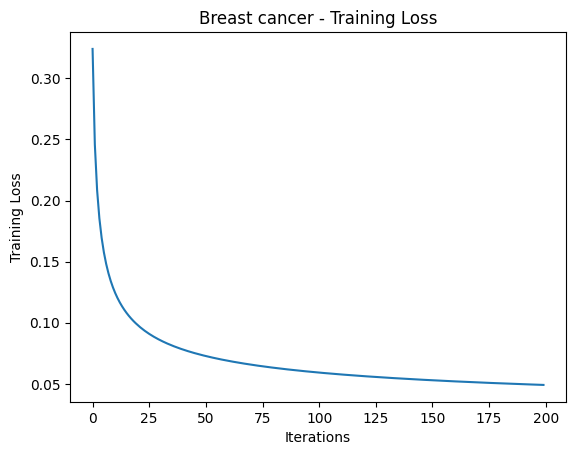

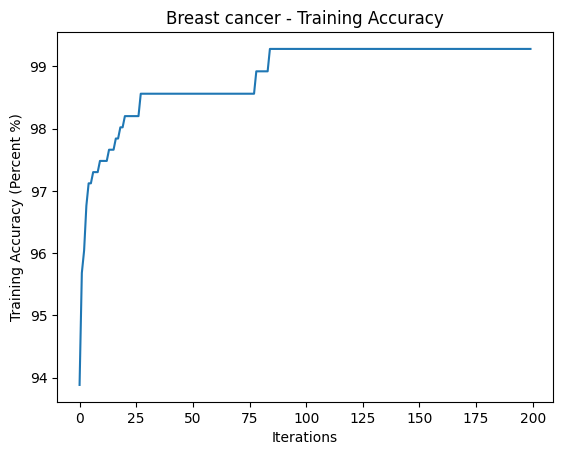

In [13]:
def plot_graphs(diagnosis_title, record):
    accuracies, losses = record
    plt.plot(losses)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    plt.plot(accuracies)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()

diagnosis_title = 'Breast cancer'
plot_graphs(diagnosis_title, recorded)

### Evaluating the Model

In [14]:
test_acc = compute_accuracy(final_model, X_test, Y_test)
print('[+] Testing Accuracy = {}'.format(to_percent(test_acc)))

[+] Testing Accuracy = 96.49%


We actually train the machine learning model to diagnose the Breast cancer. As you can see in the graphs, the training loss drops quickly to almost zero and the training accuracy reaches the 98%. The testing accuracy is also 94.74. Notice that this machine learning system diagnoses this disease in a perfect way; whereas human doctors can commit mistakes.

## Federated Learning

So far, we have used machine learning in an insecure way. Now, we introduce our proposed encrypted learning model. This is a combination of federated learning and homomorphic encryption!

<p align='center'>
    <img src='images/encrypted_learning.png'>
</p>

**Set up**

- 1. Define HE scheme, Hospitals shared a HE private key, and share with the Aggregator a public key.
- 2. Define the model that use to train.

**Local training**
- 3. Hospitals train locally with the model in plaintext, extract model updates (the final weights) and encrypt them using the private HE key.
- 4. Each hospital sends its encrypted model's weights to the Aggregator (untrusted).

**Global model weight aggregator**
- 5. Aggregator uses its public key to perform homomorphic operation on the encrypted weights to obtain new encrypted model, and send its to hospitals.

**Repeated**
- 6. Each hospital receives the decrypted model, then uses their private HE key, decrypts its to get the new model.
- 7. This process ís repeated until hospitals find the new desired model or after a termination criteria is met.

### Datasets

In [15]:
import pandas as pd

### Dataset 1

[source](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset)

**Description:**
Breast cancer is the most common cancer amongst women in the world. It accounts for 25% of all cancer cases, and affected over 2.1 Million people in 2015 alone. It starts when cells in the breast begin to grow out of control. These cells usually form tumors that can be seen via X-ray or felt as lumps in the breast area.

The key challenges against it’s detection is how to classify tumors into malignant (cancerous) or benign(non cancerous). We ask you to complete the analysis of classifying these tumors using machine learning (with SVMs) and the Breast Cancer Wisconsin (Diagnostic) Dataset.

**Acknowledgements:**
This dataset has been referred from Kaggle.

**Objective:**
* Understand the Dataset & cleanup (if required).
* Build classification models to predict whether the cancer type is Malignant or Benign.
* Also fine-tune the hyperparameters & compare the evaluation metrics of various classification algorithms.

In [16]:
df1 = pd.read_csv('data/dataset1.csv')
print("Shape:", df1.shape)
df1.head(5)

Shape: (1202, 32)


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_pts_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_pts_worst,symmetry_worst,fractal_dim_worst,diagnostic
0,561,20.47,20.67,134.70,1299.0,0.09156,0.13130,0.15230,0.10150,0.2166,...,27.15,152.00,1645.0,0.1097,0.25340,0.30920,0.16130,0.3220,0.06386,M
1,77,11.75,20.18,76.10,419.8,0.10890,0.11410,0.06843,0.03738,0.1993,...,26.21,88.91,543.9,0.1358,0.18920,0.19560,0.07909,0.3168,0.07987,B
2,151,13.77,13.27,88.06,582.7,0.09198,0.06221,0.01063,0.01917,0.1592,...,16.93,94.17,661.1,0.1170,0.10720,0.03732,0.05802,0.2823,0.06794,B
3,231,12.34,14.95,78.29,469.1,0.08682,0.04571,0.02109,0.02054,0.1571,...,16.85,84.11,533.1,0.1048,0.06744,0.04921,0.04793,0.2298,0.05974,B
4,410,13.80,15.79,90.43,584.1,0.10070,0.12800,0.07789,0.05069,0.1662,...,20.86,110.30,812.4,0.1411,0.35420,0.27790,0.13830,0.2589,0.10300,M


### Dataset 2

[source](https://www.kaggle.com/code/a3amat02/breast-cancer-classification/input)

**About this file**

* y. The outcomes. A factor with two levels denoting whether a mass is malignant ("M") or benign ("B").
* x. The predictors. A matrix with the mean, standard error and worst value of each of 10 nuclear measurements on the slide, for 30 total features per biopsy:
* radius. Nucleus radius (mean of distances from center to points on perimeter).
* texture. Nucleus texture (standard deviation of grayscale values).
* perimeter. Nucleus perimeter.
* area. Nucleus area.
* smoothness. Nucleus smoothness (local variation in radius lengths).
* compactness. Nucleus compactness (perimeter^2/area - 1).
* concavity, Nucleus concavity (severity of concave portions of the contour).
* concave_pts. Number of concave portions of the nucleus contour.
* symmetry. Nucleus symmetry.
* fractal_dim. Nucleus fractal dimension ("coastline approximation" -1).

In [17]:
df2 = pd.read_csv('data/dataset2.csv')
print("Shape:", df2.shape)
df2.head(5)

Shape: (1193, 32)


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_pts_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_pts_worst,symmetry_worst,fractal_dim_worst,diagnostic
0,374,14.68,20.13,94.74,684.5,0.09867,0.07200,0.073950,0.052590,0.1586,...,30.88,123.40,1138.0,0.14640,0.18710,0.29140,0.16090,0.3029,0.08216,M
1,325,12.34,12.27,78.94,468.5,0.09003,0.06307,0.029580,0.026470,0.1689,...,19.27,87.22,564.9,0.12920,0.20740,0.17910,0.10700,0.3110,0.07592,B
2,359,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.086900,0.070170,0.1812,...,23.41,158.80,1956.0,0.12380,0.18660,0.24160,0.18600,0.2750,0.08902,M
3,264,14.80,17.66,95.88,674.8,0.09179,0.08890,0.040690,0.022600,0.1893,...,22.74,105.90,829.5,0.12260,0.18810,0.20600,0.08308,0.3600,0.07285,B
4,161,13.50,12.71,85.69,566.2,0.07376,0.03614,0.002758,0.004419,0.1365,...,16.94,95.48,698.7,0.09023,0.05836,0.01379,0.02210,0.2267,0.06192,B


### Dataset 3

[source](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

**Data Set Information:**

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. A few of the images can be found at [Web Link]

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/


**Attribute Information:**

1) ID number

2) Diagnosis (M = malignant, B = benign)

3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)

b) texture (standard deviation of gray-scale values)

c) perimeter

d) area

e) smoothness (local variation in radius lengths)

f) compactness (perimeter^2 / area - 1.0)

g) concavity (severity of concave portions of the contour)

h) concave points (number of concave portions of the contour)

i) symmetry

j) fractal dimension ("coastline approximation" - 1)

In [18]:
df3 = pd.read_csv('data/dataset3.csv')
print("Shape:", df3.shape)
df3.head(5)

Shape: (1189, 32)


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_pts_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_pts_worst,symmetry_worst,fractal_dim_worst,diagnostic
0,529,15.49,19.97,102.40,744.7,0.11600,0.15620,0.18910,0.09113,0.1929,...,29.41,142.10,1359.0,0.1681,0.3913,0.55530,0.21210,0.3187,0.10190,M
1,365,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,28.14,110.60,897.0,0.1654,0.3682,0.26780,0.15560,0.3196,0.11510,M
2,447,13.43,19.63,85.84,565.4,0.09048,0.06288,0.05858,0.03438,0.1598,...,29.87,116.60,993.6,0.1401,0.1546,0.26440,0.11600,0.2884,0.07371,M
3,347,12.77,29.43,81.35,507.9,0.08276,0.04234,0.01997,0.01499,0.1539,...,36.00,88.10,594.7,0.1234,0.1064,0.08653,0.06498,0.2407,0.06484,B
4,27,12.00,15.65,76.95,443.3,0.09723,0.07165,0.04151,0.01863,0.2079,...,24.90,87.78,567.9,0.1377,0.2003,0.22670,0.07632,0.3379,0.07924,B


In this demo, there are 3 hospitals (with corresponding datasets above) but there could be more hospitals. The 3 hospitals cannot share the cases of their patients because they are competitors and it is necessary to protect the privacy of patients. Hence, the ML model will be learned in a federated way.

## Clients

Import openFHE library. Then run `generate_key()`, this is just a python wrapper to run `openfhe-lib/build/key_gen`. After running this files, it will create `openfhe-lib/data` folder that holds:
- `crypto_context.txt` : contain CKKS CryptoContext object
- `public_key.txt`     : contain CKKS public key
- `private_key.txt`    : contain CKKS private key
- `mult_key.txt`       : contain CKKS multiplication key

In [19]:
from openfhe_lib.ckks.openFHE import * 

# === Generate Key-pairs of CKKS Context ===
generate_keys()

First, we start by creating the `Client` class that simulate the computers of each hospital. This just rewrite the Logistic Regression process that we have implemented previously.

In [20]:
class Client:
    def __init__(self, name, data_url, enc_file, n_features, iters):
        self.id = name
        self.enc_file = enc_file  # place wher clients save encrypted weights
        
        # split data into train and test
        self.X_train, self.Y_train, self.X_test, self.Y_test = self.preprocessing(data_url)
        
        # define local training model
        self.local_model = LogisticRegression(n_features)
        
        # some helpfull stuffs
        self.decide_vectorized = np.vectorize(self.decide)
        self.to_percent = lambda x: '{:.2f}%'.format(x)
        self.num_epochs = iters
        self.accuracies = []
        self.losses = []
        
    def preprocessing(self, data_url):
        df = pd.read_csv(data_url)
        # Replace "M" with 1 and "B" with 0 at "diagnostic" column
        df["diagnostic"] = (df["diagnostic"] == "M").astype(int)
        
        # split dataframe to train and test df
        df_train, df_test = np.split(df.sample(frac=1), [int(0.8 * len(df))])
        
        # scaling and convert to tensor context
        train, X_train, Y_train = scale_dataset(df_train, True)
        test , X_test , Y_test  = scale_dataset(df_test , False)
        return X_train, Y_train, X_test, Y_test
    
    def decide(self, y):
        return 1. if y >= 0.5 else 0.
    
    def compute_accuracy(self, input, output):
        prediction = self.local_model(input).data.numpy()[:, 0]
        n_samples = prediction.shape[0] + 0.
        prediction = self.decide_vectorized(prediction)
        equal = prediction == output.data.numpy()
        return 100. * equal.sum() / n_samples
    
    def local_training(self, debug=True):
        n_samples, _ = self.X_train.shape

        # define criterion function and set up optimizer
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.SGD(self.local_model.parameters(), lr=0.01)  

        # main process
        for epoch in range(self.num_epochs):  
            optimizer.zero_grad()
            #### Compute outputs ####
            prediction = self.local_model(self.X_train)

            #### Compute gradients ####
            loss = criterion(prediction.squeeze(), self.Y_train)
            loss.backward()

            #### Update weights #### 
            optimizer.step()

            # compute accuracy and loss
            train_acc = self.compute_accuracy(self.X_train, self.Y_train)
            train_loss = loss.item()
                
            self.losses.append(train_loss)
            self.accuracies.append(train_acc)
        
            #### Logging ####
            if debug and (epoch + 1)%50 == 0:
                print('[LOG] Epoch: %05d' % (epoch + 1), end="")
                print('    | Train ACC: %s' % self.to_percent(train_acc), end="")
                print('    | Loss: %.3f' % train_loss)
    
    def encrypted_model_params(self):
        model_weights = self.local_model.linear.weight.data.squeeze().tolist()
        model_bias    = self.local_model.linear.bias.data.squeeze().tolist()
        
        model_params  = model_weights + [model_bias]
        encrypt_weights(model_params, self.enc_file)
        
    def decrypted_model_params(self):
        params = decrypt_weights("/enc_aggregator_weight_server.txt")
        # convert float to tensor context
        W = Variable(torch.tensor([params[:-1]], dtype = torch.float32))
        B = Variable(torch.tensor( params[-1], dtype = torch.float32))
        
        self.local_model.linear.weight = nn.Parameter(W)
        self.local_model.linear.bias   = nn.Parameter(B)
    
    def plot_graphs(self, diagnosis_title = 'Breast cancer'):
        plt.plot(self.losses)
        plt.title(f"{diagnosis_title} - Training Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Training Loss")
        plt.show()
        plt.plot(self.accuracies)
        plt.title(f"{diagnosis_title} - Training Accuracy")
        plt.xlabel("Iterations")
        plt.ylabel("Training Accuracy (Percent %)")
        plt.show()
    
    def print_result_after_training(self):
        print('Model parameters:')
        print('  | Weights: %s' % self.local_model.linear.weight)
        print('  | Bias: %s' % self.local_model.linear.bias)
        self.plot_graphs()
    
    def evaluating_model(self):
        test_acc = self.compute_accuracy(self.X_test, self.Y_test)
        print('[+] Testing Accuracy = {}'.format(self.to_percent(test_acc)))

## Server

We define some functions to train the machine learning model in a federated way while keeping track of the training loss and the training accuracy, for each hospital separately.

In [21]:
clients = [
    Client('Hostpital1', 'data/dataset1.csv', "/enc_weight_client1.txt", n_features=31, iters=10), 
    Client('Hostpital2', 'data/dataset2.csv', "/enc_weight_client2.txt", n_features=31, iters=10),
    Client('Hostpital3', 'data/dataset3.csv', "/enc_weight_client3.txt", n_features=31, iters=10),
    Client('Hostpital4', 'data/dataset4.csv', "/enc_weight_client4.txt", n_features=31, iters=10)
]

/home/enotari/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/enotari/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/enotari/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/enotari/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


The whole process is done in a server aggregator, in 1000 iterations (we can vary the number of iterations.) At each iteration.

In [22]:
iterations = 10000 # ponia 1000
worker_iterations = 5
to_percent = lambda x: '{:.2f}%'.format(x)
n_hospitals = len(clients)
n_features = 31
    
def compute_federated_accuracy(model, input, output):
    prediction = model(input)
    n_samples = prediction.shape[0]
    s = 0.
    for i in range(n_samples):
        p = 1. if prediction[i] >= 0.5 else 0.
        e = 1. if p == output[i] else 0.
        s += e
    return 100. * s / n_samples

def federated_learning(clients):
    # init global training model
    global_model = LogisticRegression(n_features)

    # record losses and accuracies report from clients
    losses = [[] for i in range(n_hospitals)]
    accuracies = [[] for i in range(n_hospitals)]
    
    pbar = tqdm(range(iterations), desc='Federated Learning Process')
    for iteration in pbar:
        print(f"ITERATION = {iteration}")
        if iteration:
            # print("ENTRO 1")
            # copy global model to clients
            # clients will receive the weight-aggregated from server, extract
            # the ciphertext then decrypt it to get to global_model's weights
            for i in range(n_hospitals):
                clients[i].decrypted_model_params()
        
        # perform local training for each clients then report acc and loss to server
        for i in range(n_hospitals):
            # print("ENTRO 2")
            clients[i].local_training(debug=False)
            
            # report to server
            losses[i].append(clients[i].losses[-1])
            accuracies[i].append(clients[i].accuracies[-1])
        
        # clients encrypt the final weights of local model after training
        for i in range(n_hospitals):
            # print("ENTRO 3")
            clients[i].encrypted_model_params()
        
        # server collect clients's encrypted weights then perform weight-aggregation
        # by using homomorphic operation
        with torch.no_grad():
            # print("ENTRO 4")
            # avg_weight = sum([clients[i].local_model.linear.weight.data for i in range(n_hospitals)]) / n_hospitals
            # global_model.linear.weight = nn.Parameter(avg_weight)
            # avg_bias = sum([clients[i].local_model.linear.bias.data for i in range(n_hospitals)]) / n_hospitals
            # global_model.linear.bias = nn.Parameter(avg_bias)
            aggregator()
    
        # logging
        if (iteration + 1) % 100 == 0:
            losses_str = ['{:.4f}'.format(losses[i][-1]) for i in range(n_hospitals)]
            accuracies_str = [to_percent(accuracies[i][-1]) for i in range(n_hospitals)]
            print('[LOG] Epoch = {0:04d}\n> Losses = {1}\n> Accuracies = {2}'.format(iteration + 1, losses_str, accuracies_str))
        
    return losses, accuracies

In [ ]:
losses, accuracies = federated_learning(clients)

Federated Learning Process:   0%|          | 0/10000 [00:00<?, ?it/s]

ITERATION = 0
ITERATION = 1
ITERATION = 2
ITERATION = 3
ITERATION = 4
ITERATION = 5
ITERATION = 6
ITERATION = 7
ITERATION = 8
ITERATION = 9
ITERATION = 10
ITERATION = 11
ITERATION = 12
ITERATION = 13
ITERATION = 14
ITERATION = 15
ITERATION = 16
ITERATION = 17
ITERATION = 18
ITERATION = 19
ITERATION = 20
ITERATION = 21
ITERATION = 22
ITERATION = 23
ITERATION = 24
ITERATION = 25
ITERATION = 26
ITERATION = 27
ITERATION = 28
ITERATION = 29
ITERATION = 30
ITERATION = 31
ITERATION = 32
ITERATION = 33
ITERATION = 34


### Virtualize record of training process

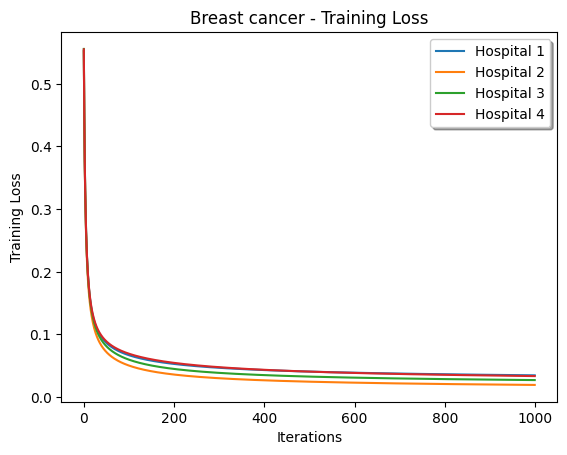

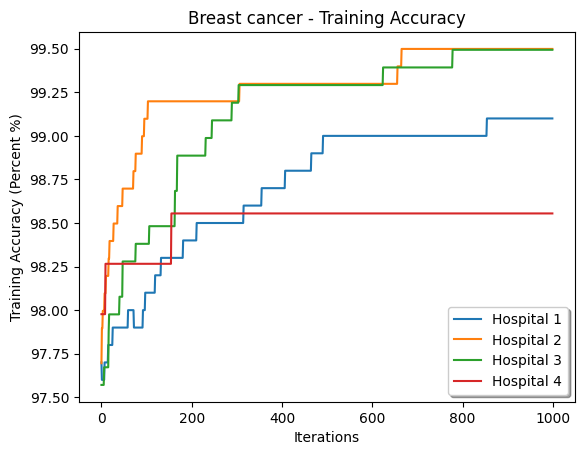

In [ ]:
def plot_federated_graphs(diagnosis_title, losses, accuracies):
    for i in range(n_hospitals):
        plt.plot(losses[i], label=f'Hospital {i+1}')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    for i in range(n_hospitals):
        plt.plot(accuracies[i], label=f'Hospital {i+1}')
    legend = plt.legend(loc='lower right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()

plot_federated_graphs('Breast cancer', losses, accuracies)

### Model parameters after training proccess

In [ ]:
clients[0].decrypted_model_params()
global_model = clients[0].local_model

print('\nModel parameters:')
print('  | Weights: %s' % global_model.linear.weight) ### Virtualize record of training processlobal_model.linear.weight)
print('  | Bias: %s' % global_model.linear.bias)

CIPHER_FILE /enc_aggregator_weight_server.txt
CWD = /home/enotari/Escritorio/Federated-Learning-meets-Homomorphic-Encryption/openfhe_lib/ckks
STDOUT = -0.67379654939647881661812789388932@0.78124421863977011604163180891192@0.081727318693110756475661560216395@0.77862314917174879624894856533501@0.562869950878444380570897465077@0.19623676686345725705962195206666@0.13515364025991491447875603171269@0.5592936126415904984909843733476@0.69513373085794172290263759350637@0.027119137768890952400191451943101@-0.60998159644491556363732343015727@0.61476485417823001355941414658446@-0.40006348516279577331999917078065@0.44380374264631189396013155601395@0.60467649992876892905968588820542@-0.13246402891977726579142426999169@-0.055545361983643570802371414174559@0.051931480728224566068007561625564@0.35068450131142758774416279266006@-0.27560101424726179963897720881505@-0.42412072416768420435317921146634@0.82705174405797010628305088175694@0.41183231741001413706015910065616@0.88976737831861008043432548220153@0

### Evaluating the Model

In [ ]:
# prepare data for testing model
df_test = pd.read_csv('data/test.csv')
df_test["diagnostic"] = (df_test["diagnostic"] == "M").astype(int)
test , X_test , Y_test  = scale_dataset(df_test , False)

test_acc = compute_federated_accuracy(global_model, X_test, Y_test)
print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))


Testing Accuracy = 89.80%


## Thanks for reading!
I hope you have enjoyed the explanations of this machine learning system with federated learning.

### References

- [1] Wibawa, F., Catak, F. O., Kuzlu, M., Sarp, S., & Cali, U. (2022, June). Homomorphic encryption and federated learning based privacy-preserving cnn training: Covid-19 detection use-case. In Proceedings of the 2022 European Interdisciplinary Cybersecurity Conference (pp. 85-90).​

- [2] Al Badawi, A., Bates, J., Bergamaschi, F., Cousins, D. B., Erabelli, S., Genise, N., ... & Zucca, V. (2022, November). OpenFHE: Open-source fully homomorphic encryption library. In Proceedings of the 10th Workshop on Encrypted Computing & Applied Homomorphic Cryptography (pp. 53-63).